In [ ]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 413.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 5.4 MB/s 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from datetime import timedelta


In [ ]:
#First we define several prediction models, then we run models for every asset and choose the best one.

In [2]:
# Model1:Prophet

def prophet_forecast_currency(file_path, asset_name="Currency"):
    # === 1. 读取数据（兼容编码和异常列名） ===
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    df.columns = df.columns.str.strip()  # 去除空格
    print(f"{asset_name} 列名为：", df.columns.tolist())

    # 尝试自动识别列名
    date_col = [col for col in df.columns if 'Date' in col or 'ï»¿Date' in col][0]
    close_col = [col for col in df.columns if 'Close' in col][0]

    df = df.rename(columns={date_col: 'ds', close_col: 'y'})
    df['y'] = df['y'].replace('[\$,]', '', regex=True).astype(float)
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')

    # === 2. 拟合 Prophet 模型（全数据） ===
    model = Prophet(daily_seasonality=True)
    model.fit(df)

    future = model.make_future_dataframe(periods=39)
    forecast = model.predict(future)

    # === 3. 可视化预测 ===
    fig = model.plot(forecast)
    plt.title(f"{asset_name} Price Forecast")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate / Price")
    plt.show()

    # === 4. 输出未来 39 天预测值 ===
    today = pd.to_datetime("today").normalize()
    future_predictions = forecast[forecast['ds'] >= today]
    print(f"\n{asset_name} Future 39-day Predictions:")
    print(future_predictions[['ds', 'yhat']].to_string(index=False))

    # === 5. 模型评估（最近 30 天） ===
    train = df.iloc[:-30]
    test = df.iloc[-30:]

    model_eva = Prophet(daily_seasonality=True)
    model_eva.fit(train)

    future = model_eva.make_future_dataframe(periods=len(test))
    forecast = model_eva.predict(future)

    test['ds'] = pd.to_datetime(test['ds'])
    forecast_on_test = model_eva.predict(test[['ds']])
    merged = pd.merge(test[['ds', 'y']], forecast_on_test[['ds', 'yhat']], on='ds')

    y_true = merged['y'].values
    y_pred = merged['yhat'].values

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\nModel Evaluation on Last 30 Days ({asset_name}):")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")


In [7]:
!pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00


In [8]:
import mlflow

In [15]:
!pip install pyngrok
!ngrok config add-authtoken 2vjtquoZGAn3ixR8CAw1eI4p8Na_2wQrEFfkddCdGvn49hdnN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [19]:

!pip install mlflow prophet pyngrok



PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [21]:
from pyngrok import ngrok

# Kill any previous ngrok or MLflow processes
!pkill -f mlflow

In [22]:
get_ipython().system_raw("mlflow ui --port 5000 &")

# Expose the MLflow UI using ngrok
public_url = ngrok.connect(addr="5000")
print(f"MLflow UI available at: {public_url}")

MLflow UI available at: NgrokTunnel: "https://06fb-34-67-141-2.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
#Model2:LSTM
def lstm_forecast(file_path, asset_name="Asset", lookback=30, epochs=20, forecast_days=21):
    # === 1. 读取 & 清洗数据 ===
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    df.columns = df.columns.str.strip()

    # 自动识别列名，解决乱码
    date_col = [col for col in df.columns if 'Date' in col or 'ï»¿Date' in col][0]
    close_col = [col for col in df.columns if 'Close' in col or 'CloseÂ' in col][0]

    df = df.rename(columns={date_col: 'ds', close_col: 'y'})
    df['y'] = df['y'].replace('[\$,]', '', regex=True).astype(float)
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')
    df = df.dropna()

    # === 2. 归一化数据 ===
    data = df['y'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # === 3. 构建 LSTM 输入序列 ===
    X, y = [], []
    for i in range(lookback, len(data_scaled)):
        X.append(data_scaled[i - lookback:i])
        y.append(data_scaled[i])
    X, y = np.array(X), np.array(y)

    # === 4. 拆分训练和测试集 ===
    split = int(len(X) * 0.9)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # === 5. 构建 LSTM 模型 ===
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    # === 6. 做回测预测 ===
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test)

    # === 7. 打印回测指标 ===
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
    mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

    print(f"\n📈 LSTM Evaluation for {asset_name}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # === 8. 可视化回测预测 ===
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_rescaled, label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.title(f"{asset_name} LSTM Backtest Prediction")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === 9. 递推预测未来 21 天 ===
    future_input = data_scaled[-lookback:].reshape(1, lookback, 1)
    future_predictions = []

    for _ in range(forecast_days):
        next_pred = model.predict(future_input)[0][0]
        future_predictions.append(next_pred)
        new_input = np.append(future_input[0][1:], [[next_pred]], axis=0)
        future_input = new_input.reshape(1, lookback, 1)

    future_preds_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # === 10. 构建未来日期表格 ===
    last_date = df['ds'].max()
    future_dates = [last_date + timedelta(days=i + 1) for i in range(forecast_days)]
    future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_preds_rescaled.flatten()})

    print(f"\n📅 {asset_name} {forecast_days}-day LSTM Future Predictions:")
    print(future_df.to_string(index=False))

    # === 11. 保存结果 ===
    future_df.to_csv(f"{asset_name}_future_lstm_predictions.csv", index=False)



In [ ]:
#Model comparison:Prophet and LSTM
def compare_lstm_prophet(file_path, asset_name="Asset", lookback=30, epochs=20):
    predict_days = 39  # ✅ 修改：你要预测的天数

    # === Step 1: Load & Clean Data ===
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    df.columns = df.columns.str.strip()
    date_col = [col for col in df.columns if 'Date' in col or 'ï»¿Date' in col][0]
    close_col = [col for col in df.columns if 'Close' in col][0]
    df = df.rename(columns={date_col: 'ds', close_col: 'y'})
    df['y'] = df['y'].replace('[\$,]', '', regex=True).astype(float)
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')
    df = df.dropna()

    # =============== PROPHET ===============
    prophet_df = df[['ds', 'y']].copy()
    train_p = prophet_df.iloc[:-predict_days]
    test_p = prophet_df.iloc[-predict_days:]

    model_p = Prophet(daily_seasonality=True)
    model_p.fit(train_p)
    future = model_p.make_future_dataframe(periods=predict_days)
    forecast = model_p.predict(future)

    forecast_test = forecast[forecast['ds'].isin(test_p['ds'])]
    y_true_p = test_p['y'].values
    y_pred_p = forecast_test['yhat'].values

    # ✅ 对齐长度，避免报错
    min_len_p = min(len(y_true_p), len(y_pred_p))
    y_true_p = y_true_p[-min_len_p:]
    y_pred_p = y_pred_p[-min_len_p:]

    mae_p = mean_absolute_error(y_true_p, y_pred_p)
    rmse_p = np.sqrt(mean_squared_error(y_true_p, y_pred_p))
    mape_p = np.mean(np.abs((y_true_p - y_pred_p) / y_true_p)) * 100

    # =============== LSTM ===============
    series = df['y'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    X, y_lstm = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y_lstm.append(scaled[i])
    X, y_lstm = np.array(X), np.array(y_lstm)

    split = len(X) - predict_days
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y_lstm[:split], y_lstm[split:]

    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
    model_lstm.add(LSTM(50))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    y_pred_scaled = model_lstm.predict(X_test)
    y_pred_l = scaler.inverse_transform(y_pred_scaled)
    y_test_l = scaler.inverse_transform(y_test)

    # ✅ 对齐长度，防止潜在错误
    min_len_l = min(len(y_test_l), len(y_pred_l))
    y_test_l = y_test_l[-min_len_l:]
    y_pred_l = y_pred_l[-min_len_l:]

    mae_l = mean_absolute_error(y_test_l, y_pred_l)
    rmse_l = np.sqrt(mean_squared_error(y_test_l, y_pred_l))
    mape_l = np.mean(np.abs((y_test_l - y_pred_l) / y_test_l)) * 100

    # =============== PRINT METRICS ===============
    print(f"\n📊 Forecast Accuracy Comparison for {asset_name} (Last {predict_days} Days)")
    print("-----------------------------------------------------------")
    print(f"Prophet → MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}, MAPE: {mape_p:.2f}%")
    print(f"LSTM    → MAE: {mae_l:.2f}, RMSE: {rmse_l:.2f}, MAPE: {mape_l:.2f}%")


In [ ]:
#Model Choice and Prediction

In [ ]:
# (f)Stock_Chevron
#choose prophet
compare_lstm_prophet("cheveron_stock.csv", asset_name="StockChevron", lookback=30, epochs=20)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/5epi8c0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/co0ny_n3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52268', 'data', 'file=/tmp/tmp2xm9iqar/5epi8c0c.json', 'init=/tmp/tmp2xm9iqar/co0ny_n3.json', 'output', 'file=/tmp/tmp2xm9iqar/prophet_modeleeiq2vqo/prophet_model-20250411065421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:54:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:54:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step

📊 Forecast Accuracy Comparison for StockChevron (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 7.00, RMSE: 7.33, MAPE: 4.49%
LSTM    → MAE: 2.00, RMSE: 2.62, MAPE: 1.30%


Chevron 列名为： ['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


<ipython-input-2-7edf4121126a>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/f5w6bq7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/wmpysjsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26386', 'data', 'file=/tmp/tmpir5l13lm/f5w6bq7s.json', 'init=/tmp/tmpir5l13lm/wmpysjsl.json', 'output', 'file=/tmp/tmpir5l13lm/prophet_model4g28d3ea/prophet_model-20250414230325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] d

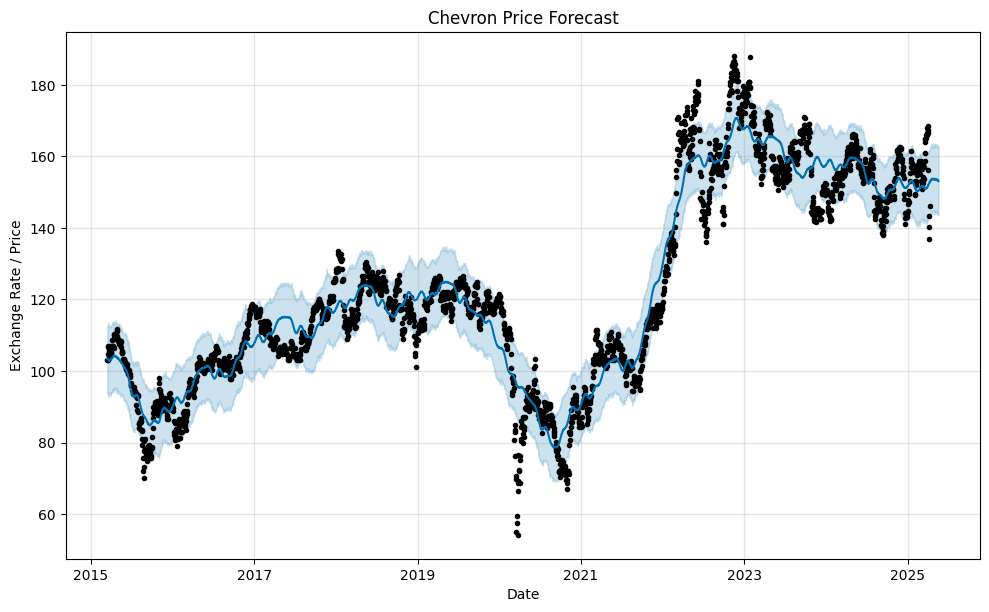

DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/ox50whae.json



Chevron Future 39-day Predictions:
        ds       yhat
2025-04-14 153.287284
2025-04-15 153.525952
2025-04-16 153.426800
2025-04-17 153.489361
2025-04-18 153.583408
2025-04-19 153.471430
2025-04-20 153.497596
2025-04-21 153.595306
2025-04-22 153.774878
2025-04-23 153.621510
2025-04-24 153.635280
2025-04-25 153.686281
2025-04-26 153.537106
2025-04-27 153.531821
2025-04-28 153.603530
2025-04-29 153.762091
2025-04-30 153.592099
2025-05-01 153.592920
2025-05-02 153.633862
2025-05-03 153.476691
2025-05-04 153.464646
2025-05-05 153.530029
2025-05-06 153.681963
2025-05-07 153.504395
2025-05-08 153.496163
2025-05-09 153.526177
2025-05-10 153.355956
2025-05-11 153.328644
2025-05-12 153.376608
2025-05-13 153.509180
2025-05-14 153.310658
2025-05-15 153.280347
2025-05-16 153.287724
2025-05-17 153.094941
2025-05-18 153.045816


DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/chrud7qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35539', 'data', 'file=/tmp/tmpir5l13lm/ox50whae.json', 'init=/tmp/tmpir5l13lm/chrud7qm.json', 'output', 'file=/tmp/tmpir5l13lm/prophet_modely6qjpco7/prophet_model-20250414230328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation on Last 30 Days (Chevron):
MAE:  11.49
RMSE: 13.03
MAPE: 7.17%


<ipython-input-2-7edf4121126a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [27]:
#StockChevron prophet forecast
prophet_forecast_currency("/content/drive/MyDrive/243 /Module 3_Asset data file/cheveron_stock.csv", asset_name="Chevron")

In [25]:
# (f)Stock_XOM
#choose prophet
compare_lstm_prophet("stock_XOM.csv", asset_name="StockXOM", lookback=30, epochs=20)

NameError: name 'compare_lstm_prophet' is not defined

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-4-7edf4121126a>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/uxu2ic9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/ln386yc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96991', 'data', 'file=/tmp/tmpp2c6h8b6/uxu2ic9_.json', 'init=/tmp/tmpp2c6h8b6/ln386yc_.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelu3bu6rb_/prophet_model-20250410175636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


XOM 列名为： ['ï»¿Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


17:56:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


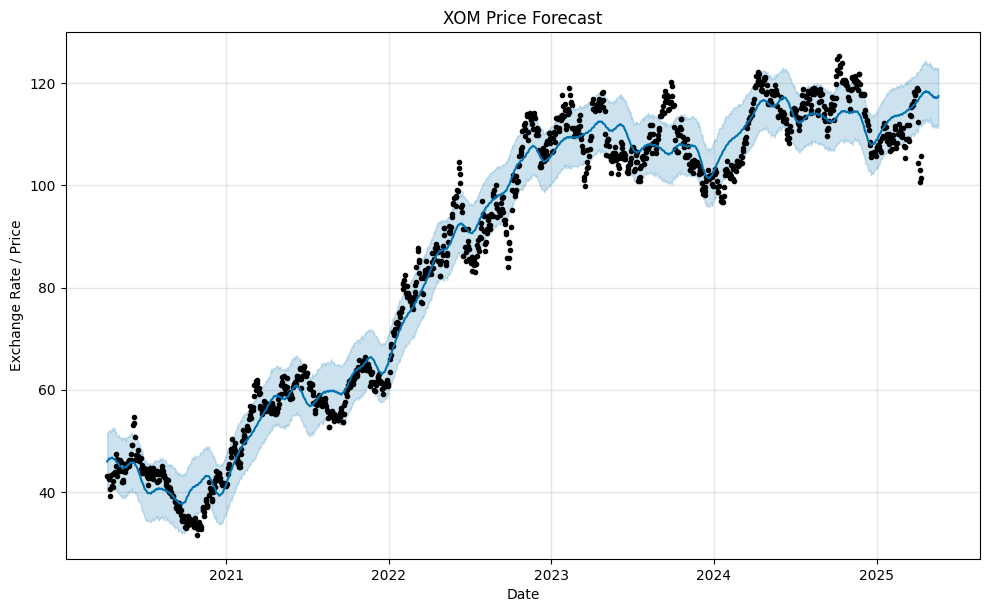

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/8bvfi267.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/rzai9wop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6097', 'data', 'file=/tmp/tmpp2c6h8b6/8bvfi267.json', 'init=/tmp/tmpp2c6h8b6/rzai9wop.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_model8c_46bug/prophet_model-20250410175637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



XOM Future 39-day Predictions:
        ds       yhat
2025-04-10 117.472427
2025-04-11 117.672309
2025-04-12 117.759561
2025-04-13 117.868058
2025-04-14 118.119609
2025-04-15 118.146002
2025-04-16 118.165589
2025-04-17 118.158254
2025-04-18 118.293858
2025-04-19 118.309682
2025-04-20 118.340443
2025-04-21 118.508948
2025-04-22 118.448128
2025-04-23 118.377593
2025-04-24 118.278586
2025-04-25 118.322396
2025-04-26 118.247775
2025-04-27 118.190927
2025-04-28 118.276130
2025-04-29 118.137735
2025-04-30 117.996703
2025-05-01 117.835519
2025-05-02 117.826588
2025-05-03 117.709624
2025-05-04 117.621616
2025-05-05 117.687437
2025-05-06 117.541827
2025-05-07 117.405923
2025-05-08 117.262163
2025-05-09 117.282684
2025-05-10 117.206714
2025-05-11 117.170548
2025-05-12 117.298161
2025-05-13 117.223217
2025-05-14 117.165607
2025-05-15 117.106382
2025-05-16 117.216175
2025-05-17 117.232615
2025-05-18 117.290334
2025-05-19 117.511609


17:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation on Last 30 Days (XOM):
MAE:  9.53
RMSE: 11.22
MAPE: 8.82%


<ipython-input-4-7edf4121126a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [ ]:
#StockXOM prophet forecast
prophet_forecast_currency("stock_XOM.csv", asset_name="XOM")

In [ ]:
# (g)Stock_COP
#choose prophet
compare_lstm_prophet("stock_COP.csv", asset_name="StockCOP", lookback=30, epochs=20)

<ipython-input-9-c03bee0be124>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/px8vxbmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/52fr4kmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41255', 'data', 'file=/tmp/tmpp2c6h8b6/px8vxbmy.json', 'init=/tmp/tmpp2c6h8b6/52fr4kmo.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelggo51_q6/prophet_model-20250410172400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] d

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step

📊 Forecast Accuracy Comparison for StockCOP (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 7.36, RMSE: 10.05, MAPE: 8.16%
LSTM    → MAE: 4.29, RMSE: 5.90, MAPE: 4.65%


<ipython-input-4-7edf4121126a>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/iwcugn4y.json


COP 列名为： ['ï»¿Date', 'Open', 'High', 'Low', 'CloseÂ', 'Adj CloseÂ', 'Volume']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/09l88ep9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48602', 'data', 'file=/tmp/tmpp2c6h8b6/iwcugn4y.json', 'init=/tmp/tmpp2c6h8b6/09l88ep9.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_model3o6uawer/prophet_model-20250410175720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


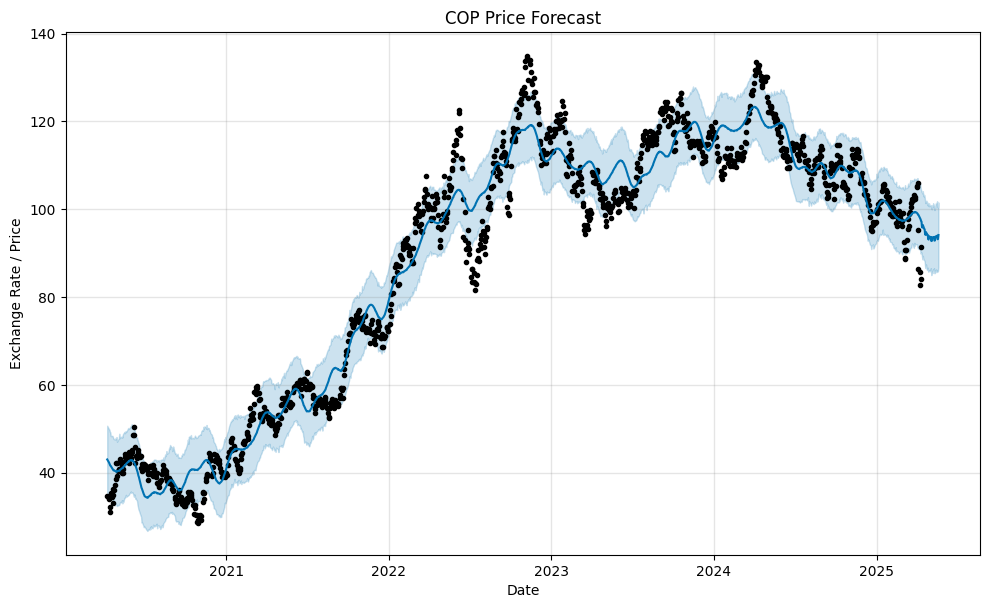

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/iyrjz0du.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/ceuw7vbu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None



COP Future 39-day Predictions:
        ds      yhat
2025-04-10 97.333579
2025-04-11 97.209755
2025-04-12 96.090547
2025-04-13 95.831455
2025-04-14 96.422298
2025-04-15 96.146340
2025-04-16 95.907217
2025-04-17 95.556897
2025-04-18 95.451738
2025-04-19 94.366768
2025-04-20 94.156450
2025-04-21 94.809339
2025-04-22 94.607251
2025-04-23 94.452223
2025-04-24 94.194516
2025-04-25 94.188719
2025-04-26 93.208068
2025-04-27 93.105257
2025-04-28 93.867138
2025-04-29 93.773922
2025-04-30 93.726180
2025-05-01 93.572866
2025-05-02 93.667451
2025-05-03 92.782254
2025-05-04 92.769263
2025-05-05 93.614838
2025-05-06 93.598907
2025-05-07 93.621953
2025-05-08 93.533024
2025-05-09 93.685838
2025-05-10 92.853089
2025-05-11 92.887237
2025-05-12 93.775170
2025-05-13 93.797371
2025-05-14 93.854864
2025-05-15 93.797187
2025-05-16 93.978468
2025-05-17 93.171698
2025-05-18 93.229492
2025-05-19 94.138741


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9910', 'data', 'file=/tmp/tmpp2c6h8b6/iyrjz0du.json', 'init=/tmp/tmpp2c6h8b6/ceuw7vbu.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_models2oq5dgh/prophet_model-20250410175722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-4-7edf4121126a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])



Model Evaluation on Last 30 Days (COP):
MAE:  8.51
RMSE: 10.78
MAPE: 9.37%


In [ ]:
#StockCOP prophet forecast
prophet_forecast_currency("stock_COP.csv", asset_name="COP")

In [ ]:
# (i)Stock_ups
#choose prophet
compare_lstm_prophet("ups_stock.csv", asset_name="StockUPS", lookback=30, epochs=20)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/m5v5mram.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/i662j04t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87136', 'data', 'file=/tmp/tmp2xm9iqar/m5v5mram.json', 'init=/tmp/tmp2xm9iqar/i662j04t.json', 'output', 'file=/tmp/tmp2xm9iqar/prophet_modelubf656w0/prophet_model-20250411065528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:55:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:55:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step

📊 Forecast Accuracy Comparison for StockUPS (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 4.31, RMSE: 5.16, MAPE: 3.72%
LSTM    → MAE: 2.99, RMSE: 4.99, MAPE: 2.55%


<ipython-input-5-7edf4121126a>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/brxoo3l2.json


UPS 列名为： ['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/woyz0s_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88552', 'data', 'file=/tmp/tmp2xm9iqar/brxoo3l2.json', 'init=/tmp/tmp2xm9iqar/woyz0s_o.json', 'output', 'file=/tmp/tmp2xm9iqar/prophet_model38pgydbn/prophet_model-20250411072735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:27:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


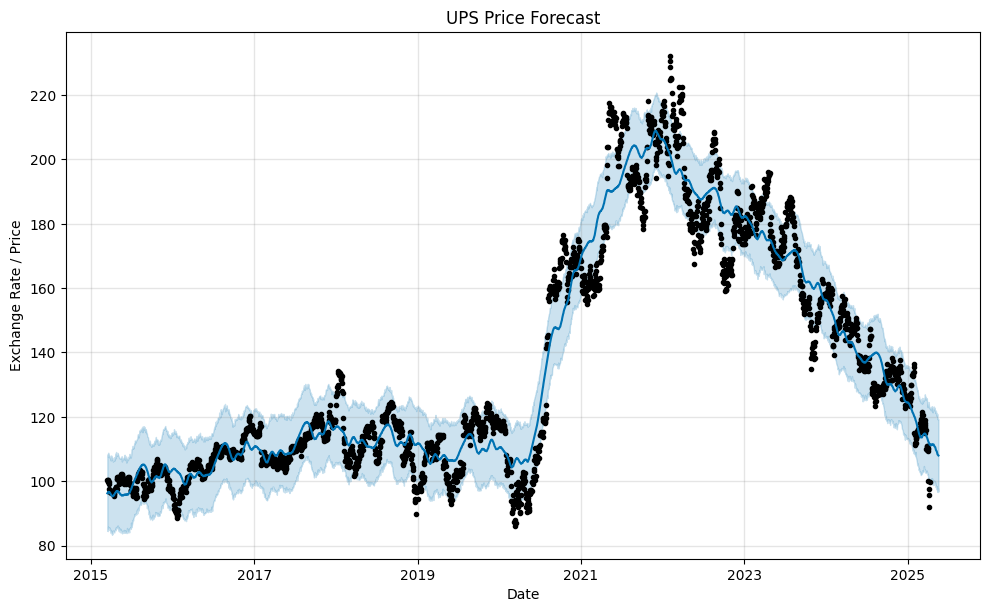

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/yobbzwva.json



UPS Future 39-day Predictions:
        ds       yhat
2025-04-11 111.358592
2025-04-12 111.417703
2025-04-13 111.394419
2025-04-14 111.256303
2025-04-15 111.249389
2025-04-16 111.124735
2025-04-17 111.235306
2025-04-18 111.342622
2025-04-19 111.464094
2025-04-20 111.484724
2025-04-21 111.371209
2025-04-22 111.369232
2025-04-23 111.230016
2025-04-24 111.307195
2025-04-25 111.363425
2025-04-26 111.417688
2025-04-27 111.356938
2025-04-28 111.150144
2025-04-29 111.045514
2025-04-30 110.796976
2025-05-01 110.760970
2025-05-02 110.702988
2025-05-03 110.644794
2025-05-04 110.476003
2025-05-05 110.168051
2025-05-06 109.971361
2025-05-07 109.641769
2025-05-08 109.537275
2025-05-09 109.424549
2025-05-10 109.326132
2025-05-11 109.132003
2025-05-12 108.813553
2025-05-13 108.620769
2025-05-14 108.308679
2025-05-15 108.234142
2025-05-16 108.162394
2025-05-17 108.114304
2025-05-18 107.977994


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2xm9iqar/_onky9yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64916', 'data', 'file=/tmp/tmp2xm9iqar/yobbzwva.json', 'init=/tmp/tmp2xm9iqar/_onky9yr.json', 'output', 'file=/tmp/tmp2xm9iqar/prophet_modelgkbingpr/prophet_model-20250411072737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:27:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:27:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation on Last 30 Days (UPS):
MAE:  5.79
RMSE: 7.87
MAPE: 5.49%


<ipython-input-5-7edf4121126a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [ ]:
#StockUPS prophet forecast
prophet_forecast_currency("ups_stock.csv", asset_name="UPS")

In [ ]:
# (i)Stock_DAL
#choose LSTM
compare_lstm_prophet("stock_DAL.csv", asset_name="StockDAL", lookback=30, epochs=20)

<ipython-input-9-c03bee0be124>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/c6nzvpbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/g0gy3z_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16574', 'data', 'file=/tmp/tmpp2c6h8b6/c6nzvpbw.json', 'init=/tmp/tmpp2c6h8b6/g0gy3z_z.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelvg9oxwyv/prophet_model-20250410172501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] d

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step

📊 Forecast Accuracy Comparison for StockDAL (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 21.32, RMSE: 21.80, MAPE: 48.76%
LSTM    → MAE: 2.33, RMSE: 2.78, MAPE: 5.00%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step

📈 LSTM Evaluation for DAL
MAE:  1.96
RMSE: 2.55
MAPE: 3.64%


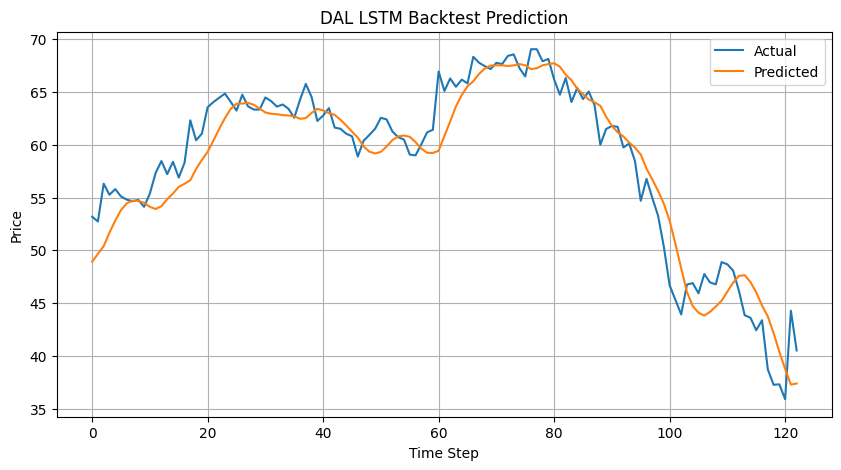

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

📅 DAL 21-day LSTM Future Predictions:
        ds      yhat
2025-04-11 37.705456
2025-04-12 37.777588
2025-04-13 37.761265
2025-04-14 37.702728
2025-04-15 37.627602
2025-04-16 37.546326
2025-04-17 37.46

In [ ]:
#StockDAL LSTM forecast
lstm_forecast("stock_DAL.csv", asset_name="DAL", lookback=30, epochs=20)

In [ ]:
# (j)Stock_AAL
#choose LSTM
compare_lstm_prophet("stock_AAL.csv", asset_name="StockAAL", lookback=30, epochs=20)

<ipython-input-9-c03bee0be124>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/7f1zrjeh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/f4hhxqud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95950', 'data', 'file=/tmp/tmpp2c6h8b6/7f1zrjeh.json', 'init=/tmp/tmpp2c6h8b6/f4hhxqud.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modely8bvoi02/prophet_model-20250410172614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] d

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step

📊 Forecast Accuracy Comparison for StockAAL (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 5.38, RMSE: 5.48, MAPE: 50.16%
LSTM    → MAE: 0.57, RMSE: 0.72, MAPE: 5.00%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step

📈 LSTM Evaluation for AAL
MAE:  0.50
RMSE: 0.65
MAPE: 3.53%


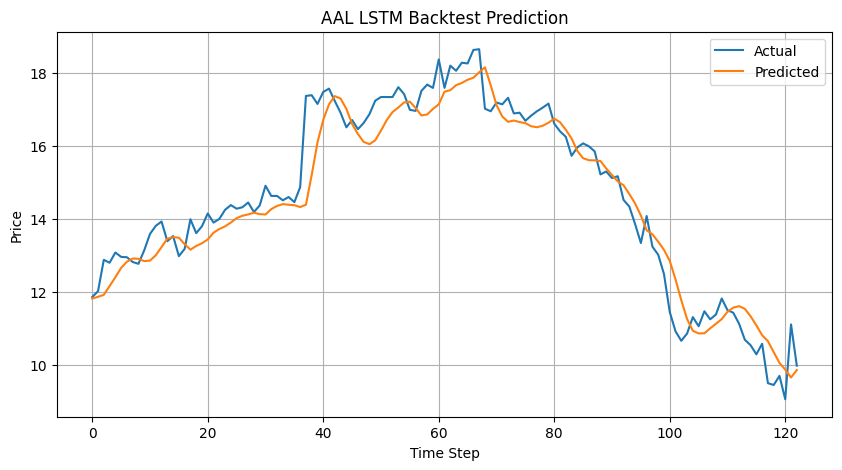

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

📅 AAL 21-day LSTM Future Predictions:
        ds      yhat
2025-04-11 10.011425
2025-04-12 10.115051
2025-04-13 10.202882
2025-04-14 10.283250
2025-04-15 10.359745
2025-04-16 10.432564
2025-04-17 1

In [ ]:
#StockAAL LSTM forecast
lstm_forecast("stock_AAL.csv", asset_name="AAL", lookback=30, epochs=20)

In [ ]:
# (k)Stock_TSLA
#choose LSTM
compare_lstm_prophet("stock_TSLA.csv", asset_name="StockTSLA", lookback=30, epochs=20)

<ipython-input-17-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/uxb3v_hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/vf6in8le.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67222', 'data', 'file=/tmp/tmpp2c6h8b6/uxb3v_hk.json', 'init=/tmp/tmpp2c6h8b6/vf6in8le.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modeld4g1sa2i/prophet_model-20250410172900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step

📊 Forecast Accuracy Comparison for StockTSLA (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 107.74, RMSE: 110.11, MAPE: 43.49%
LSTM    → MAE: 17.70, RMSE: 22.44, MAPE: 6.56%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step

📈 LSTM Evaluation for TSLA
MAE:  19.67
RMSE: 25.22
MAPE: 5.95%


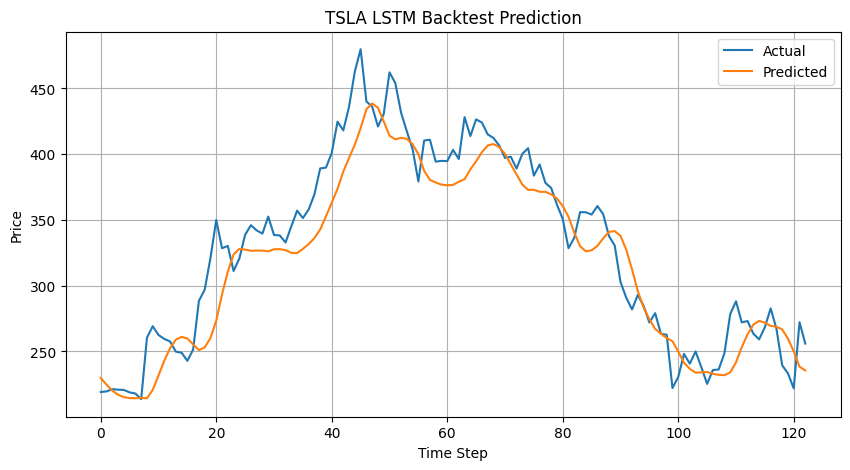

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

📅 TSLA 21-day LSTM Future Predictions:
        ds       yhat
2025-04-11 235.755692
2025-04-12 235.103928
2025-04-13 234.119202
2025-04-14 232.933197
2025-04-15 231.681259
2025-04-16 230.392715
2025-

In [ ]:
#StockTSLA LSTM forecast
lstm_forecast("stock_TSLA.csv", asset_name="TSLA", lookback=30, epochs=20)

In [ ]:
# (l)Stock_NIO
#choose LSTM
compare_lstm_prophet("stock_NIO.csv", asset_name="StockNIO", lookback=30, epochs=20)

<ipython-input-17-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/y6dn3lji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/ts58z98m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41993', 'data', 'file=/tmp/tmpp2c6h8b6/y6dn3lji.json', 'init=/tmp/tmpp2c6h8b6/ts58z98m.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_model33rwr42q/prophet_model-20250410173058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step

📊 Forecast Accuracy Comparison for StockNIO (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 4.71, RMSE: 4.90, MAPE: 114.87%
LSTM    → MAE: 0.36, RMSE: 0.45, MAPE: 9.01%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step

📈 LSTM Evaluation for NIO
MAE:  0.51
RMSE: 0.58
MAPE: 11.55%


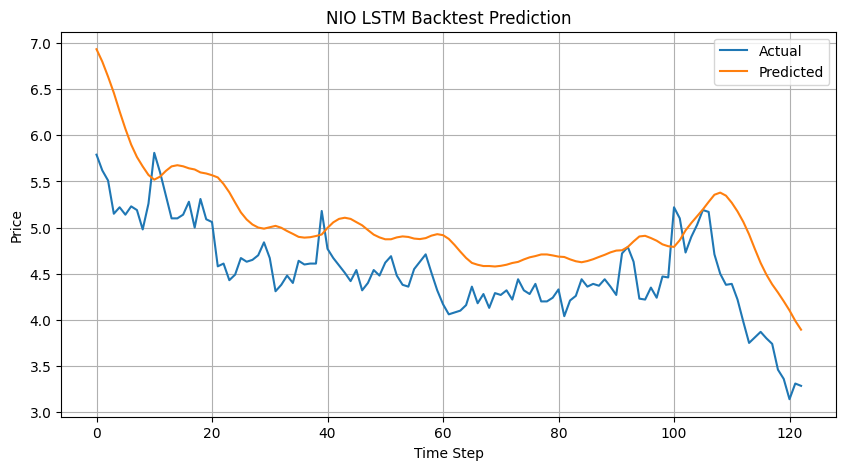

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📅 NIO 21-day LSTM Future Predictions:
        ds     yhat
2025-04-11 3.816052
2025-04-12 3.805434
2025-04-13 3.837480
2025-04-14 3.896002
2025-04-15 3.970794
2025-04-16 4.055541
2025-04-17 4.146241
2

In [ ]:
#StockNIO LSTM forecast
lstm_forecast("stock_NIO.csv", asset_name="NIO", lookback=30, epochs=20)

In [ ]:
# (o)Currency_RUB
#choose LSTM
compare_lstm_prophet("currency_RUB.csv", asset_name="CurrencyRUB", lookback=30, epochs=20)

<ipython-input-22-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/vifw927p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/asjjbof2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25380', 'data', 'file=/tmp/tmpp2c6h8b6/vifw927p.json', 'init=/tmp/tmpp2c6h8b6/asjjbof2.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelttda1cb4/prophet_model-20250410173514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step

📊 Forecast Accuracy Comparison for CurrencyRUB (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 23.46, RMSE: 24.09, MAPE: 27.68%
LSTM    → MAE: 3.85, RMSE: 4.35, MAPE: 4.46%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

📈 LSTM Evaluation for CurrencyRUB
MAE:  2.26
RMSE: 3.16
MAPE: 2.28%


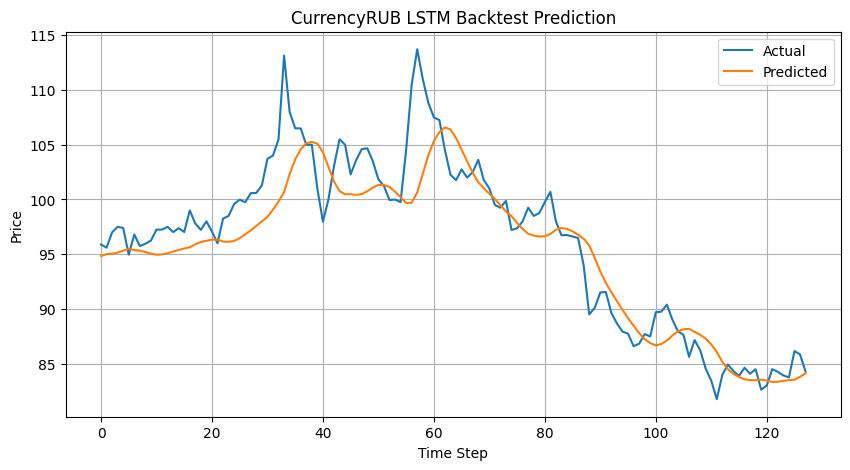

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

📅 CurrencyRUB 21-day LSTM Future Predictions:
        ds      yhat
2025-04-11 84.285095
2025-04-12 84.363075
2025-04-13 84.382095
2025-04-14 84.354866
2025-04-15 84.300133
2025-04-16 84.224731
2025-04

In [ ]:
#Currency_RUB LSTM forecast
lstm_forecast("currency_RUB.csv", asset_name="CurrencyRUB", lookback=30, epochs=20)

In [ ]:
# (p)Currency_CAD
#choose prophet
compare_lstm_prophet("currency_CAD.csv", asset_name="CurrencyCAD", lookback=30, epochs=20)

<ipython-input-22-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/46yery0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/ykyz428r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44788', 'data', 'file=/tmp/tmpp2c6h8b6/46yery0z.json', 'init=/tmp/tmpp2c6h8b6/ykyz428r.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modely919b8dy/prophet_model-20250410173823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step

📊 Forecast Accuracy Comparison for CurrencyCAD (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 0.03, RMSE: 0.03, MAPE: 2.02%
LSTM    → MAE: 0.01, RMSE: 0.01, MAPE: 0.46%


<ipython-input-4-7edf4121126a>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/qhbiizt9.json


CAD 列名为： ['ï»¿Date', 'Open', 'High', 'Low', 'CloseÂ', 'Adj CloseÂ', 'Volume']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/v626y885.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68720', 'data', 'file=/tmp/tmpp2c6h8b6/qhbiizt9.json', 'init=/tmp/tmpp2c6h8b6/v626y885.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelb251y2g0/prophet_model-20250410180616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


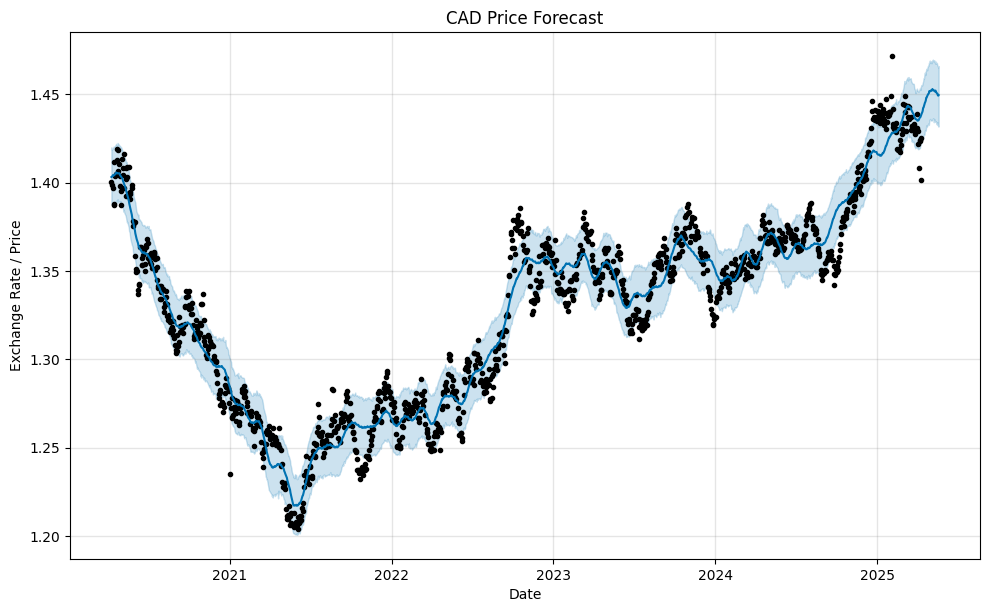

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/uebecfy4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/ag0x3w96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79422', 'data', 'file=/tmp/tmpp2c6h8b6/uebecfy4.json', 'init=/tmp/tmpp2c6h8b6/ag0x3w96.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_model1h309yfy/prophet_model-20250410180618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



CAD Future 39-day Predictions:
        ds     yhat
2025-04-10 1.438406
2025-04-11 1.439251
2025-04-12 1.439771
2025-04-13 1.440600
2025-04-14 1.442245
2025-04-15 1.442538
2025-04-16 1.443482
2025-04-17 1.444223
2025-04-18 1.445156
2025-04-19 1.445696
2025-04-20 1.446480
2025-04-21 1.448018
2025-04-22 1.448147
2025-04-23 1.448876
2025-04-24 1.449358
2025-04-25 1.449994
2025-04-26 1.450206
2025-04-27 1.450637
2025-04-28 1.451806
2025-04-29 1.451554
2025-04-30 1.451897
2025-05-01 1.451993
2025-05-02 1.452247
2025-05-03 1.452086
2025-05-04 1.452154
2025-05-05 1.452974
2025-05-06 1.452386
2025-05-07 1.452410
2025-05-08 1.452201
2025-05-09 1.452165
2025-05-10 1.451725
2025-05-11 1.451528
2025-05-12 1.452091
2025-05-13 1.451255
2025-05-14 1.451037
2025-05-15 1.450589
2025-05-16 1.450318
2025-05-17 1.449645
2025-05-18 1.449216
2025-05-19 1.449549


18:06:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation on Last 30 Days (CAD):
MAE:  0.02
RMSE: 0.02
MAPE: 1.57%


<ipython-input-4-7edf4121126a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [ ]:
#CurrencyCAD prophet forecast
prophet_forecast_currency("currency_CAD.csv", asset_name="CAD")

In [ ]:
# (q)Currency_JPY
#choose LSTM
compare_lstm_prophet("currency_JPY.csv", asset_name="CurrencyJPY", lookback=30, epochs=20)

<ipython-input-22-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/zo7qj13d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/k2ez5_ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11876', 'data', 'file=/tmp/tmpp2c6h8b6/zo7qj13d.json', 'init=/tmp/tmpp2c6h8b6/k2ez5_ke.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modela8ecv659/prophet_model-20250410173919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step

📊 Forecast Accuracy Comparison for CurrencyJPY (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 9.07, RMSE: 9.25, MAPE: 6.12%
LSTM    → MAE: 1.31, RMSE: 1.57, MAPE: 0.88%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

📈 LSTM Evaluation for CurrencyJPY
MAE:  1.40
RMSE: 1.81
MAPE: 0.92%


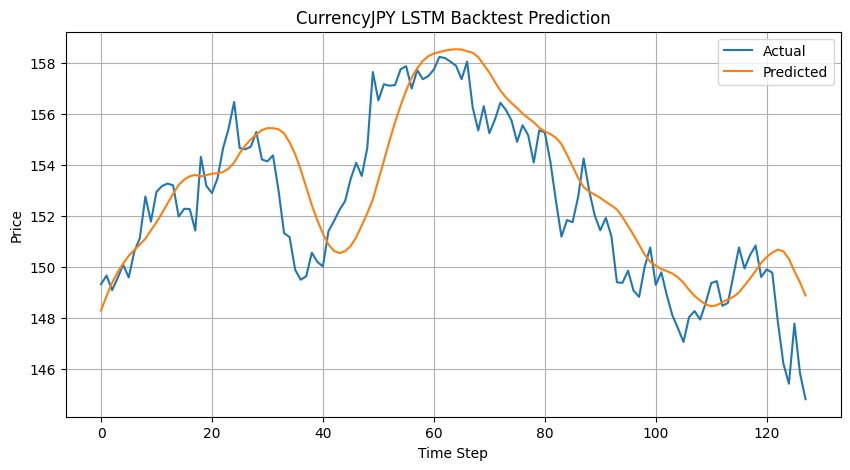

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

📅 CurrencyJPY 21-day LSTM Future Predictions:
        ds       yhat
2025-04-11 148.296860
2025-04-12 147.919113
2025-04-13 147.680252
2025-04-14 147.544540
2025-04-15 147.486786
2025-04-16 147.484604


In [ ]:
#Currency_JPY LSTM forecast
lstm_forecast("currency_JPY.csv", asset_name="CurrencyJPY", lookback=30, epochs=20)

In [ ]:
# (r)Currency_INR
#choose Prophet
compare_lstm_prophet("currency_INR.csv", asset_name="CurrencyINR", lookback=30, epochs=20)

<ipython-input-22-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/yamekcfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/330knlhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82361', 'data', 'file=/tmp/tmpp2c6h8b6/yamekcfx.json', 'init=/tmp/tmpp2c6h8b6/330knlhq.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelhmk26ogg/prophet_model-20250410174005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step

📊 Forecast Accuracy Comparison for CurrencyINR (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 0.84, RMSE: 1.00, MAPE: 0.98%
LSTM    → MAE: 0.40, RMSE: 0.48, MAPE: 0.46%


<ipython-input-4-7edf4121126a>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/ytjx6aia.json


INR 列名为： ['ï»¿Date', 'Open', 'High', 'Low', 'CloseÂ', 'Adj CloseÂ', 'Volume']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/i4j9sg8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61369', 'data', 'file=/tmp/tmpp2c6h8b6/ytjx6aia.json', 'init=/tmp/tmpp2c6h8b6/i4j9sg8d.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_modelcrqp04cu/prophet_model-20250410181010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


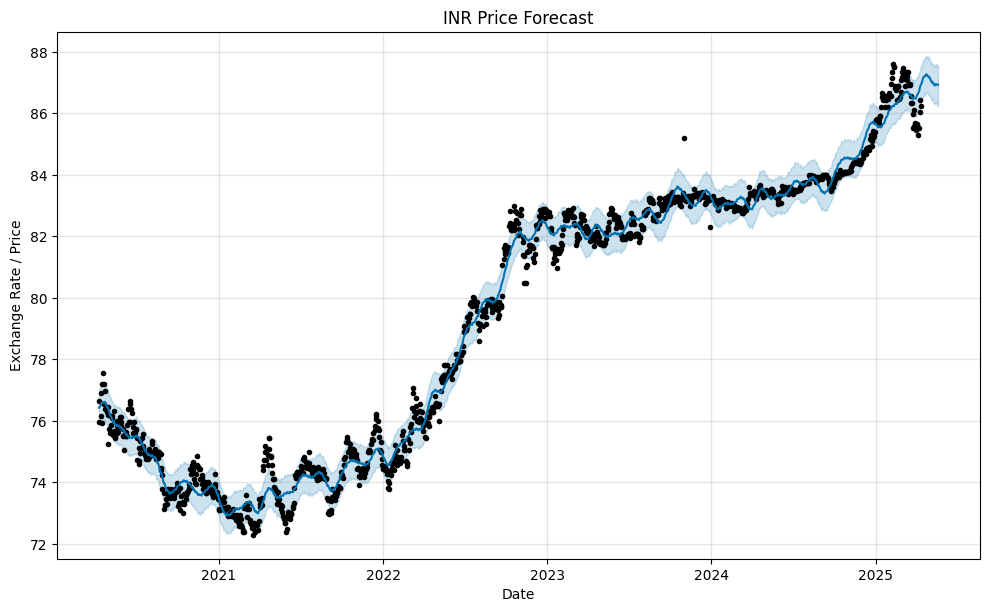

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/9x4bg4c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/q4s2eyyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77904', 'data', 'file=/tmp/tmpp2c6h8b6/9x4bg4c8.json', 'init=/tmp/tmpp2c6h8b6/q4s2eyyr.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_model4tslb4_p/prophet_model-20250410181011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



INR Future 39-day Predictions:
        ds      yhat
2025-04-10 86.893656
2025-04-11 86.932388
2025-04-12 86.958441
2025-04-13 87.002097
2025-04-14 87.031159
2025-04-15 87.111550
2025-04-16 87.151712
2025-04-17 87.174045
2025-04-18 87.192656
2025-04-19 87.194906
2025-04-20 87.211581
2025-04-21 87.211052
2025-04-22 87.259863
2025-04-23 87.267111
2025-04-24 87.255875
2025-04-25 87.240946
2025-04-26 87.210354
2025-04-27 87.195529
2025-04-28 87.165445
2025-04-29 87.187190
2025-04-30 87.170340
2025-05-01 87.138373
2025-05-02 87.106393
2025-05-03 87.062650
2025-05-04 87.038698
2025-05-05 87.003536
2025-05-06 87.024185
2025-05-07 87.010059
2025-05-08 86.984388
2025-05-09 86.961948
2025-05-10 86.930597
2025-05-11 86.921440
2025-05-12 86.902981
2025-05-13 86.941718
2025-05-14 86.946526
2025-05-15 86.940097
2025-05-16 86.936683
2025-05-17 86.923643
2025-05-18 86.931621
2025-05-19 86.928718


18:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation on Last 30 Days (INR):
MAE:  1.02
RMSE: 1.28
MAPE: 1.19%


<ipython-input-4-7edf4121126a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [ ]:
#Currency_INR Prophet forecast
prophet_forecast_currency("currency_INR.csv", asset_name="INR")

In [ ]:
# (s)VIX
#choose LSTM
compare_lstm_prophet("VIX.csv", asset_name="VIX", lookback=30, epochs=20)

<ipython-input-22-d2dd16bafaec>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/lhxmvm14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2c6h8b6/rnw3snk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54589', 'data', 'file=/tmp/tmpp2c6h8b6/lhxmvm14.json', 'init=/tmp/tmpp2c6h8b6/rnw3snk0.json', 'output', 'file=/tmp/tmpp2c6h8b6/prophet_model15zc7y4z/prophet_model-20250410174051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step

📊 Forecast Accuracy Comparison for VIX (Last 39 Days)
-----------------------------------------------------------
Prophet → MAE: 7.66, RMSE: 11.94, MAPE: 23.38%
LSTM    → MAE: 2.80, RMSE: 4.83, MAPE: 9.70%


<ipython-input-34-83bfa9393774>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step

📈 LSTM Evaluation for VIX
MAE:  1.80
RMSE: 3.27
MAPE: 8.46%


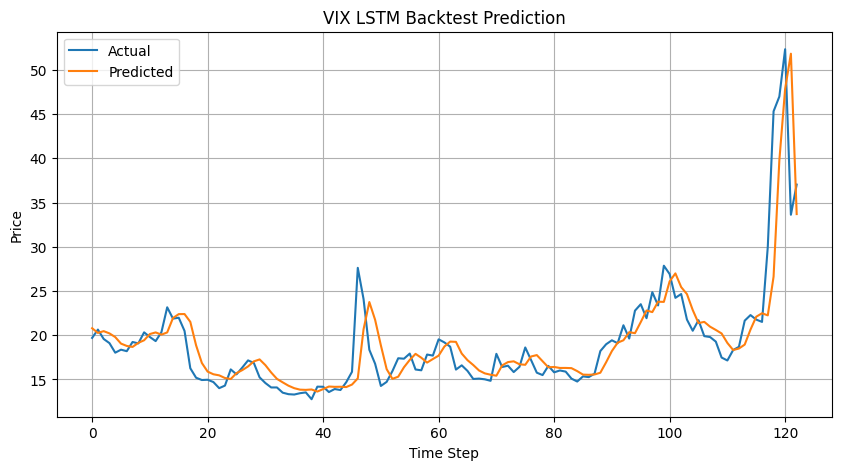

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

📅 VIX 21-day LSTM Future Predictions:
        ds      yhat
2025-04-11 31.456064
2025-04-12 30.241131
2025-04-13 30.067713
2025-04-14 30.468369
2025-04-15 31.088736
2025-04-16 31.722168
2025-04-17 32.26

In [ ]:
#VIX LSTM forecast
lstm_forecast("VIX.csv", asset_name="VIX", lookback=30, epochs=20)

<ipython-input-17-1bd8b0ddd9e6>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oil['ds'] = pd.to_datetime(oil['ds'])
<ipython-input-17-1bd8b0ddd9e6>:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
<ipython-input-17-1bd8b0ddd9e6>:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
<ipython-input-17-1bd8b0ddd9e6>:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df

A preview of the merged data：
          ds    Oil  Chevron    XOM    COP     UPS    DAL    AAL   TSLA   NIO  \
0 2020-04-13  1.951    84.91  42.76  34.30   98.42  23.25  11.56  43.40  2.97   
1 2020-04-20  1.910    83.57  41.18  34.57  101.20  23.64  11.06  49.76  3.19   
2 2020-04-27  1.870    89.71  43.94  37.15  102.55  22.16  10.02  53.25  3.24   
3 2020-05-04  1.883    91.44  44.88  40.36   90.44  22.57   9.82  50.75  3.34   
4 2020-05-11  1.941    93.37  45.74  42.27   93.91  22.01  10.10  54.09  3.74   

       RUB     CAD      JPY      INR    VIX  
0  73.6633  1.3968  108.336  76.1665  41.17  
1  74.0651  1.4048  107.670  76.5600  43.83  
2  74.5933  1.4108  107.495  76.2715  33.29  
3  75.4275  1.4135  106.738  75.6005  35.97  
4  73.3934  1.3924  106.919  75.5250  27.57  

correlation matrix：
              Oil   Chevron       XOM       COP       UPS       DAL       AAL  \
Oil      1.000000  0.807201  0.671652  0.769080  0.412251  0.128151  0.044038   
Chevron  0.807201  1.000

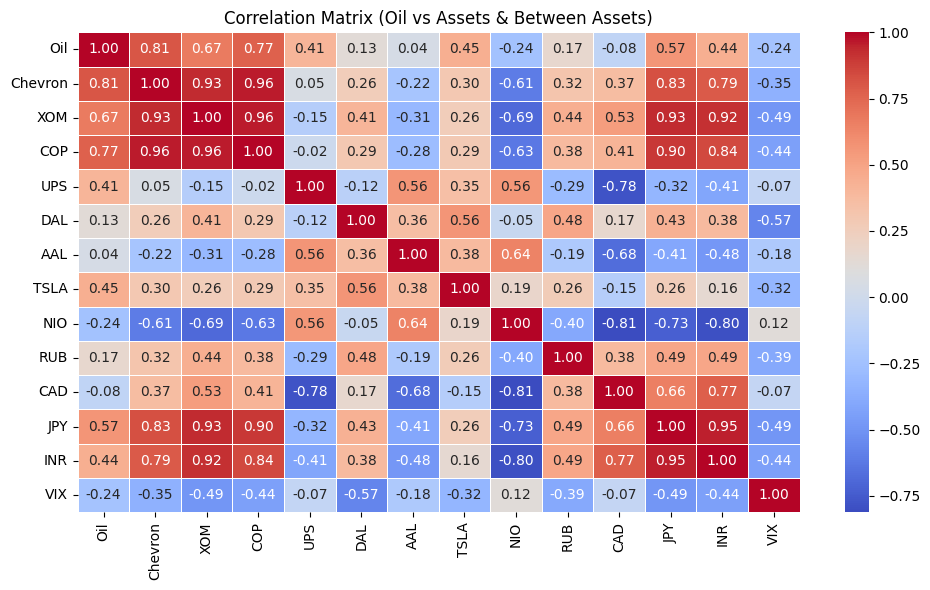

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 设置分析时间区间 ===
start_date = "2020-04-09"

# === 2. 读取并截取 oil price ===
oil = pd.read_csv("Gasoline Prices 2010-2025.3.3.csv")
oil.columns = oil.columns.str.strip()
oil = oil.rename(columns={'Date': 'ds', 'Price': 'OIL'})
oil['ds'] = pd.to_datetime(oil['ds'])
oil = oil[oil['ds'] >= start_date]  # 截取时间区间

# === 3. 读取多个资产价格数据 ===
assets = {
    "Chevron": "cheveron_stock.csv",
    "XOM": "stock_XOM.csv",
    "COP": "stock_COP.csv",
    "UPS": "ups_stock.csv",
    "DAL": "stock_DAL.csv",
    "AAL": "stock_AAL.csv",
    "TSLA": "stock_TSLA.csv",
    "NIO": "stock_NIO.csv",
    "RUB": "currency_RUB.csv",
    "CAD": "currency_CAD.csv",
    "JPY": "currency_JPY.csv",
    "INR": "currency_INR.csv",
    "VIX": "VIX.csv"
}

# 逐个读取并合并
merged = oil[['ds', 'Oil']].copy()

for name, file in assets.items():
    df = pd.read_csv(file, encoding='ISO-8859-1')
    df.columns = df.columns.str.strip()
    date_col = [col for col in df.columns if 'Date' in col or 'ï»¿Date' in col][0]
    close_col = [col for col in df.columns if 'Close' in col][0]
    df = df.rename(columns={date_col: 'ds', close_col: name})
    df['ds'] = pd.to_datetime(df['ds'])
    df[name] = df[name].replace('[\$,]', '', regex=True).astype(float)
    merged = merged.merge(df[['ds', name]], on='ds', how='inner')

# === 4. 输出对齐后的数据结构检查 ===
print("A preview of the merged data：")
print(merged.head())

# === 5. 计算相关性矩阵 ===
corr_matrix = merged.drop(columns='ds').corr()

print("\ncorrelation matrix：")
print(corr_matrix)

# === 6. 画出热力图 ===
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Oil vs Assets & Between Assets)")
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import mlflow
import mlflow.prophet
import os

def prophet_forecast_currency(file_path, asset_name="Currency"):
    # Set up the MLflow experiment
    mlflow.set_experiment("Prophet_Currency_Forecast")

    # Start an MLflow run
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        print(f"MLflow run started with run ID: {run_id}")

        # Log the asset name as a parameter
        mlflow.log_param("asset_name", asset_name)

        # --- Step 1: Load and Prepare Data ---
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
        df.columns = df.columns.str.strip()  # Remove any extra whitespace

        # Identify date and close columns automatically
        date_col_candidates = [col for col in df.columns if 'Date' in col or 'ï»¿Date' in col]
        if not date_col_candidates:
            raise ValueError("No date column found in the file!")
        date_col = date_col_candidates[0]
        close_col_candidates = [col for col in df.columns if 'Close' in col]
        if not close_col_candidates:
            raise ValueError("No close column found in the file!")
        close_col = close_col_candidates[0]

        # Rename columns for Prophet
        df = df.rename(columns={date_col: 'ds', close_col: 'y'})
        df['y'] = df['y'].replace('[\$,]', '', regex=True).astype(float)
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values('ds')

        # --- Step 2: Fit Prophet Model and Forecast Future Values ---
        model = Prophet(daily_seasonality=True)
        model.fit(df)
        future = model.make_future_dataframe(periods=39)
        forecast = model.predict(future)

        # Log the trained Prophet model to MLflow
        mlflow.prophet.log_model(model, artifact_path="model")

        # --- Step 3: Generate and Log Forecast Plot ---
        fig = model.plot(forecast)
        plt.title(f"{asset_name} Price Forecast")
        plt.xlabel("Date")
        plt.ylabel("Exchange Rate / Price")
        forecast_plot_path = f"{asset_name}_forecast_plot.png"
        fig.savefig(forecast_plot_path)
        mlflow.log_artifact(forecast_plot_path)
        plt.close(fig)
        print(f"Forecast plot saved as {forecast_plot_path} and logged as an artifact.")

        # --- Display Future Predictions (Next 39 Days) ---
        today = pd.to_datetime("today").normalize()
        future_predictions = forecast[forecast['ds'] >= today]
        print(f"\n{asset_name} Future 39-day Predictions:")
        print(future_predictions[['ds', 'yhat']].to_string(index=False))

        # --- Step 4: Model Evaluation on Last 30 Days ---
        if len(df) < 30:
            print("Not enough data for model evaluation (need at least 30 rows).")
        else:
            train = df.iloc[:-30]
            test = df.iloc[-30:]
            model_eva = Prophet(daily_seasonality=True)
            model_eva.fit(train)
            forecast_on_test = model_eva.predict(test[['ds']])
            merged = pd.merge(test[['ds', 'y']], forecast_on_test[['ds', 'yhat']], on='ds')

            y_true = merged['y'].values
            y_pred = merged['yhat'].values

            mae = np.mean(np.abs(y_true - y_pred))
            rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            print(f"\nModel Evaluation on Last 30 Days ({asset_name}):")
            print(f"MAE:  {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAPE: {mape:.2f}%")

            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAPE", mape)

        print("MLflow run complete. Check the MLflow UI for details.")


In [29]:
#StockChevron prophet forecast
prophet_forecast_currency("/content/drive/MyDrive/243 /Module 3_Asset data file/cheveron_stock.csv", asset_name="Chevron")

2025/04/14 23:14:41 INFO mlflow.tracking.fluent: Experiment with name 'Prophet_Currency_Forecast' does not exist. Creating a new experiment.


MLflow run started with run ID: 5ca8217664184e22b921be0f035b2b54


<ipython-input-28-db5ffa97712a>:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/kxottyr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/bm_m5tki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20915', 'data', 'file=/tmp/tmpir5l13lm/kxottyr3.json', 'init=/tmp/tmpir5l13lm/bm_m5tki.json', 'output', 'file=/tmp/tmpir5l13lm/prophet_modelkmammovu/prophet_model-20250414231444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] 

Forecast plot saved as Chevron_forecast_plot.png and logged as an artifact.

Chevron Future 39-day Predictions:
        ds       yhat
2025-04-14 153.287284
2025-04-15 153.525952
2025-04-16 153.426800
2025-04-17 153.489361
2025-04-18 153.583408
2025-04-19 153.471430
2025-04-20 153.497596
2025-04-21 153.595306
2025-04-22 153.774878
2025-04-23 153.621510
2025-04-24 153.635280
2025-04-25 153.686281
2025-04-26 153.537106
2025-04-27 153.531821
2025-04-28 153.603530
2025-04-29 153.762091
2025-04-30 153.592099
2025-05-01 153.592920
2025-05-02 153.633862
2025-05-03 153.476691
2025-05-04 153.464646
2025-05-05 153.530029
2025-05-06 153.681963
2025-05-07 153.504395
2025-05-08 153.496163
2025-05-09 153.526177
2025-05-10 153.355956
2025-05-11 153.328644
2025-05-12 153.376608
2025-05-13 153.509180
2025-05-14 153.310658
2025-05-15 153.280347
2025-05-16 153.287724
2025-05-17 153.094941
2025-05-18 153.045816


DEBUG:cmdstanpy:input tempfile: /tmp/tmpir5l13lm/_7q6fts3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17958', 'data', 'file=/tmp/tmpir5l13lm/wbkkpbmz.json', 'init=/tmp/tmpir5l13lm/_7q6fts3.json', 'output', 'file=/tmp/tmpir5l13lm/prophet_modelom66ca_q/prophet_model-20250414231451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation on Last 30 Days (Chevron):
MAE:  11.49
RMSE: 13.03
MAPE: 7.17%
MLflow run complete. Check the MLflow UI for details.
